[View in Colaboratory](https://colab.research.google.com/github/karangautam/machine_learning_examples/blob/master/Humpback_Whale_Identification_Challenge.ipynb)

In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karangautam","key":"7886fb75a6cbe6a3bf59d84dcbab4904"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Jun  3 10:17 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 /content/.kaggle/kaggle.json

In [7]:
# List available datasets.
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge         15           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11230            True  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5420            True  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2463            True  


In [8]:
!kaggle competitions list -s whale

ref                                              deadline             category      reward  teamCount  userHasEntered  
-----------------------------------------------  -------------------  ----------  --------  ---------  --------------  
noaa-right-whale-recognition                     2016-01-07 23:59:00  Research     $10,000        364           False  
the-icml-2013-whale-challenge-right-whale-redux  2013-06-17 23:59:59  Research        $500        129           False  
whale-categorization-playground                  2018-07-09 23:59:00  Playground     Kudos        344            True  
whale-detection-challenge                        2013-04-08 00:00:00  Featured     $10,000        245           False  
datasciencebowl                                  2015-03-16 23:59:00  Featured    $175,000       1049           False  


In [9]:
!kaggle competitions download -c whale-categorization-playground

sample_submission.csv: Downloaded 960KB of 960KB to /content/.kaggle/competitions/whale-categorization-playground
train.csv: Downloaded 221KB of 221KB to /content/.kaggle/competitions/whale-categorization-playground
test.zip: Downloaded 405MB of 405MB to /content/.kaggle/competitions/whale-categorization-playground
train.zip: Downloaded 260MB of 260MB to /content/.kaggle/competitions/whale-categorization-playground


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split



In [75]:
from subprocess import check_output
print(check_output(["ls", "../content/.kaggle/competitions/whale-categorization-playground"]).decode("utf8"))
print(check_output(["ls", "../content/.kaggle/competitions/whale-categorization-playground/train/train"]).decode("utf8"))



sample_submission.csv
test.zip
train
train.csv
train.zip

00022e1a.jpg
000466c4.jpg
00087b01.jpg
001296d5.jpg
0014cfdf.jpg
0025e8c2.jpg
0026a8ab.jpg
0031c258.jpg
0035632e.jpg
0037e7d3.jpg
00389cd7.jpg
0042dcc4.jpg
0042ea34.jpg
00467ae9.jpg
004a97f3.jpg
004c5fb9.jpg
005c57e7.jpg
006d0aaf.jpg
0078af23.jpg
007c3603.jpg
00863b8c.jpg
008809b5.jpg
008baccf.jpg
0091c92b.jpg
009dca38.jpg
00a29f63.jpg
00aa021c.jpg
00ab018e.jpg
00ac0e86.jpg
00acb5a9.jpg
00ad9219.jpg
00af84d8.jpg
00b2c0cd.jpg
00b588d6.jpg
00b7de10.jpg
00be7f73.jpg
00be9148.jpg
00cf7bd3.jpg
00d3d48c.jpg
00d6b82e.jpg
00ded600.jpg
00eab0e6.jpg
00ec0dcd.jpg
00f22419.jpg
00f4c92c.jpg
0101d22b.jpg
010ecbb5.jpg
010f1fe2.jpg
011904f8.jpg
01228da4.jpg
012621f1.jpg
01274a1e.jpg
01321d88.jpg
01496f0b.jpg
0162c72f.jpg
01679a6d.jpg
01692e13.jpg
0171d221.jpg
0175c4c1.jpg
017ec31f.jpg
018722ca.jpg
018f26da.jpg
01981e98.jpg
019cd867.jpg
01aaa81a.jpg
01b83639.jpg
01bd341c.jpg
01be6c48.jpg
01c11eaf.jpg
01c28f3b.jpg
01cf1430.jpg
01cf2e2e.jpg
01d117

In [54]:
!unzip -f "../content/.kaggle/competitions/whale-categorization-playground/train.zip"

Archive:  ../content/.kaggle/competitions/whale-categorization-playground/train.zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("../content/.kaggle/competitions/whale-categorization-playground/train.zip", "r")
zip_ref.extractall("../content/.kaggle/competitions/whale-categorization-playground")
zip_ref.close()

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_images = glob("../content/.kaggle/competitions/whale-categorization-playground/train/*jpg")
test_images = glob("../content/.kaggle/competitions/whale-categorization-playground/test/*jpg")
df = pd.read_csv("../content/.kaggle/competitions/whale-categorization-playground/train.csv")

df["Image"] = df["Image"].map( lambda x : "../content/.kaggle/competitions/whale-categorization-playground/train/"+x)
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

In [79]:
df['Image'].head()

0    ../content/.kaggle/competitions/whale-categori...
1    ../content/.kaggle/competitions/whale-categori...
2    ../content/.kaggle/competitions/whale-categori...
3    ../content/.kaggle/competitions/whale-categori...
4    ../content/.kaggle/competitions/whale-categori...
Name: Image, dtype: object

In [0]:
SIZE = 64

In [0]:
#image are imported with a resizing and a black and white conversion
def ImportImage( filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]
train_img = np.array([ImportImage( img) for img in train_images])
x = train_img

In [82]:
print( "%d training images" %x.shape[0])

print( "Nbr of samples/class\tNbr of classes")
for index, val in df["Id"].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t%d" %(index,val))

9850 training images
Nbr of samples/class	Nbr of classes
1			2220
2			1034
3			492
4			192
5			102
6			61
7			40
8			23
9			21
10			9
11			7
12			7
13			9
14			5
15			4
16			5
17			4
18			2
19			2
20			1
21			3
22			3
23			1
26			1
27			1
34			1
810			1


In [0]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

In [0]:
#constructing class weights
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform( [[x]])
CountDict = dict( df["Id"].value_counts())
class_weight_dic = { lohe.le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

In [0]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

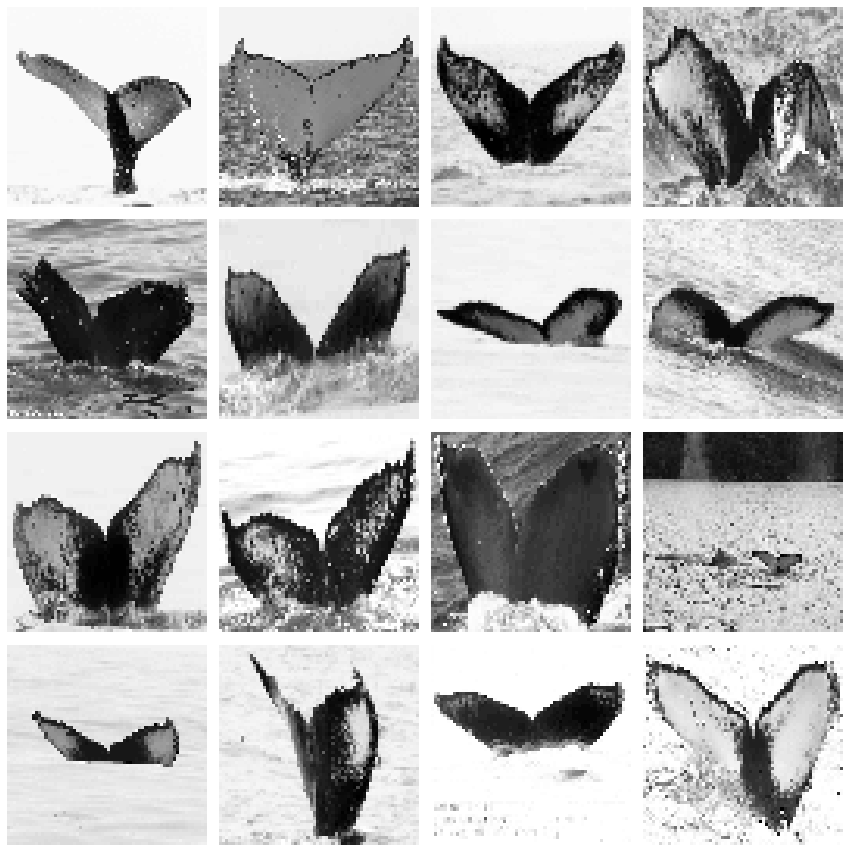

In [85]:
plotImages(x)

In [0]:
#use of an image generator for preprocessing and data augmentation
x = x.reshape( (-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

#visualization of some images out of the preprocessing
#augmented_images, _ = next( image_gen.flow( x_train, y_train.toarray(), batch_size=4*4))
#plotImages( augmented_images)

In [92]:
batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = 3

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(48, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(48, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(36, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

x_train shape: (9850, 64, 64, 1)
9850 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 48)        480       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 48)        57648     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 48)          0         
_________________________________________________________________
flatten_3 (Flatten)     

In [94]:
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=  x_train.shape[0]//batch_size,
          epochs=9,
          verbose=1,
          class_weight=class_weight_dic)


Epoch 1/9
76/76 [==============================] - 7s 96ms/step - loss: 4.1487 - acc: 0.0823
Epoch 2/9
76/76 [==============================] - 8s 104ms/step - loss: 4.1545 - acc: 0.0821
Epoch 3/9
76/76 [==============================] - 8s 105ms/step - loss: 4.1339 - acc: 0.0826
Epoch 4/9
76/76 [==============================] - 8s 104ms/step - loss: 4.1514 - acc: 0.0829
Epoch 5/9
63/76 [=======================>......] - ETA: 1s - loss: 4.1505 - acc: 0.0820

76/76 [==============================] - 8s 105ms/step - loss: 4.1483 - acc: 0.0810
Epoch 6/9
76/76 [==============================] - 8s 105ms/step - loss: 4.1469 - acc: 0.0821
Epoch 7/9
76/76 [==============================] - 8s 104ms/step - loss: 4.1545 - acc: 0.0825
Epoch 8/9
76/76 [==============================] - 8s 105ms/step - loss: 4.1382 - acc: 0.0823
Epoch 9/9
76/76 [==============================] - 8s 104ms/step - loss: 4.1515 - acc: 0.0812
